In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import siglib

Define Constants
---

In [2]:
from siglib import data_m

results = []
min_depth = 100; clonality = (0, 0.4); notation = 'pyrimidine'

EG10gff_file = '/home/clint/essigmann_analysis/AFB1/data/EG10_corrected.gff'
EG10fasta_file = '/home/clint/essigmann_analysis/AFB1/data/EG10_corrected.fasta'
merfile = '/home/clint/essigmann_analysis/AFB1/data/EG10_slice_counts.jf'

Read in Trinucleotide Frequencies of Reference Genome
---

In [3]:
from jellywrap import Jellyfish, dna_notation

j = Jellyfish()
_ = j.read_mer_file(merfile)

Parse all Files and Plot Mutations *per* Genomic Position
---

Sample: 1642
Found 148 Mutations
Sample: 1643
Found 98 Mutations
Sample: 1644
Found 192 Mutations
Sample: 8114
Found 366 Mutations
Sample: 1639
Found 9 Mutations
Sample: 1640
Found 11 Mutations
Sample: 1641
Found 6 Mutations
Sample: 4508
Found 279 Mutations
Sample: 4509
Found 1134 Mutations
Sample: 8113
Found 227 Mutations


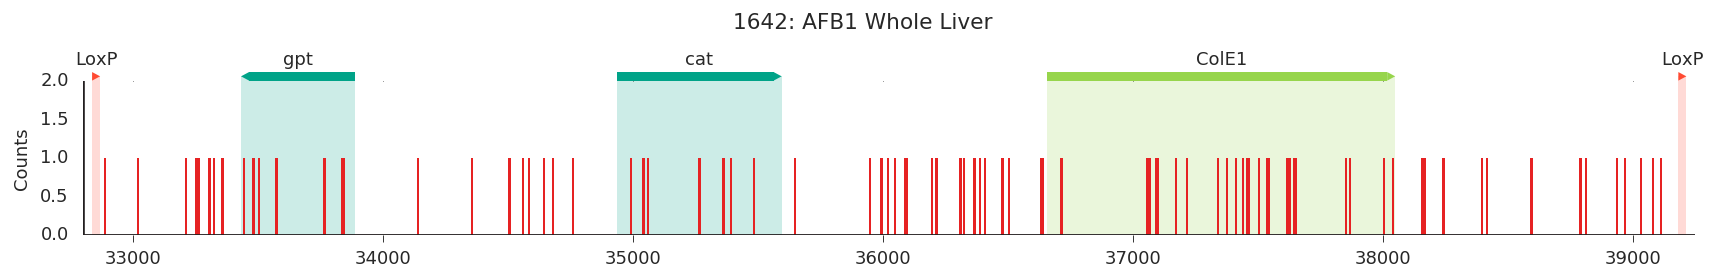

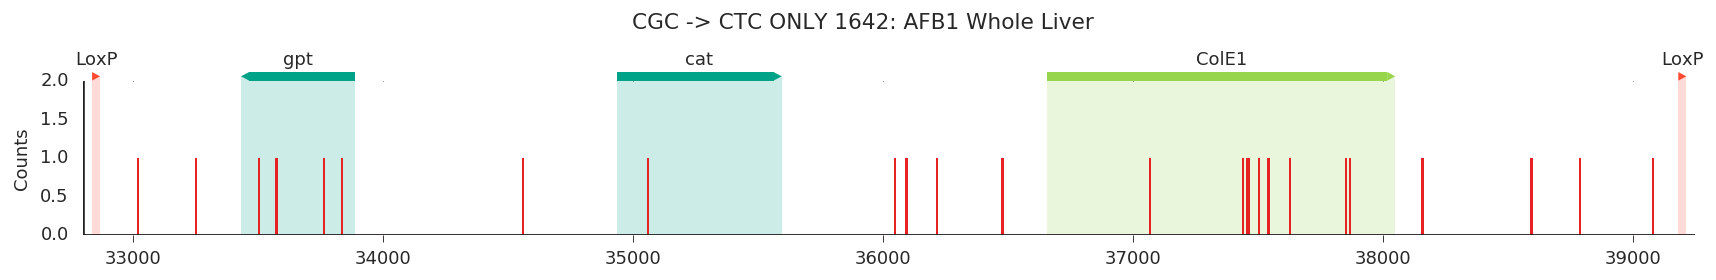

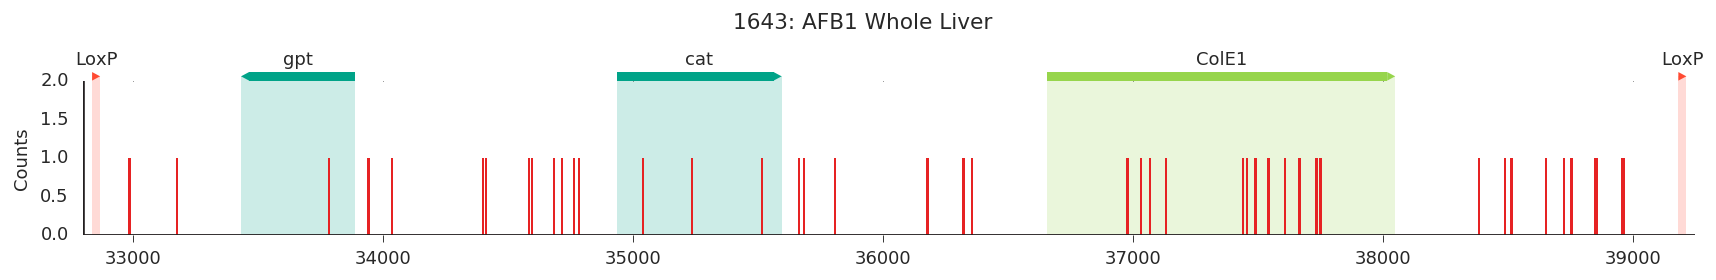

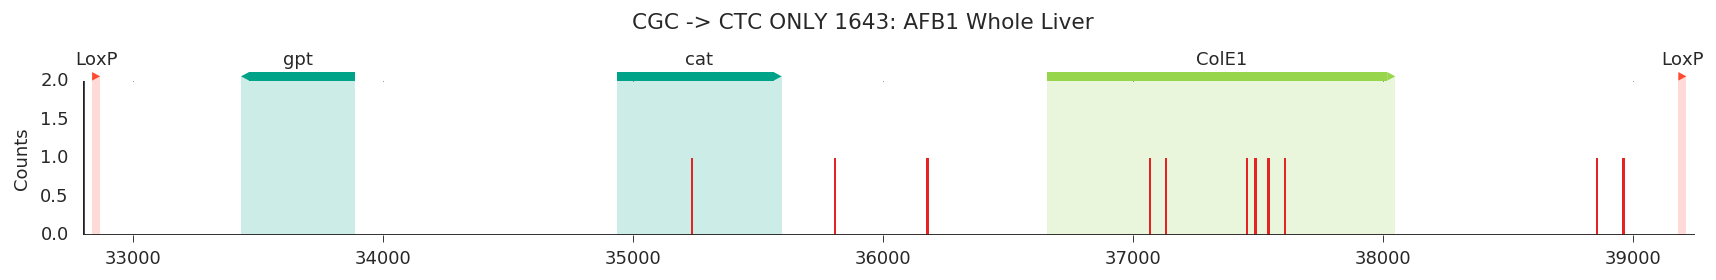

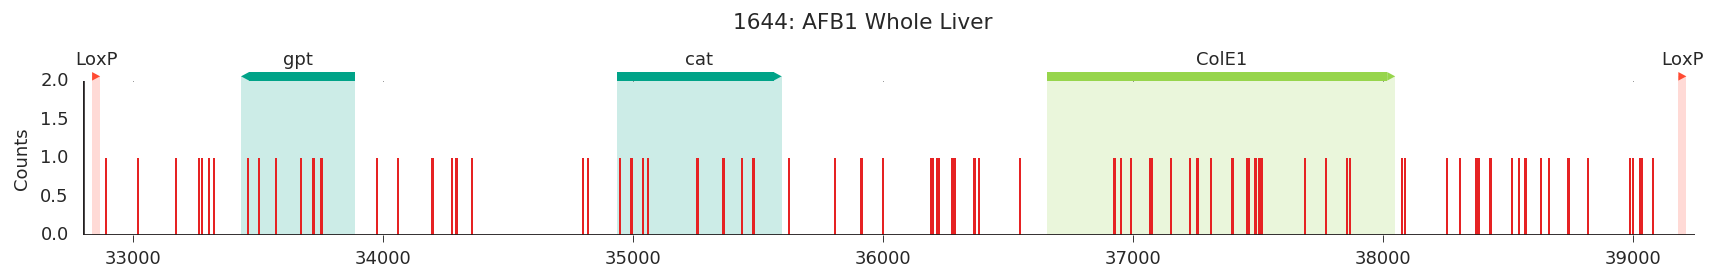

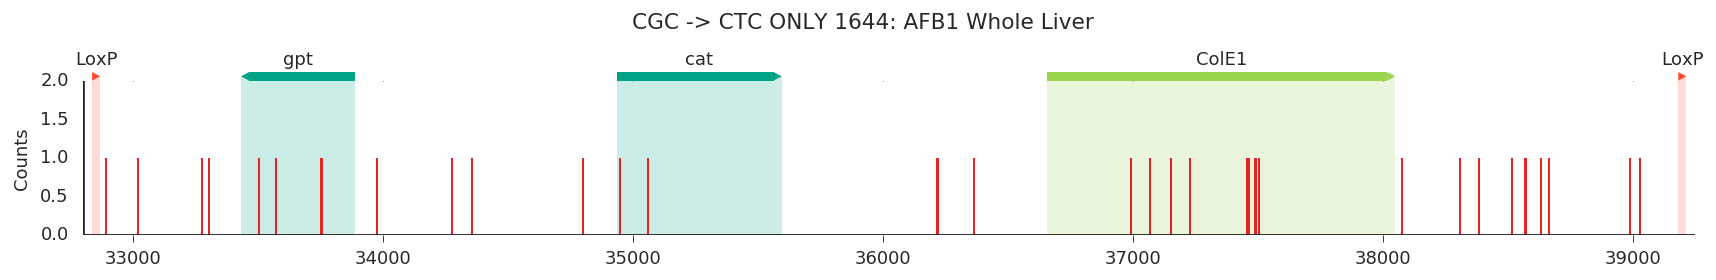

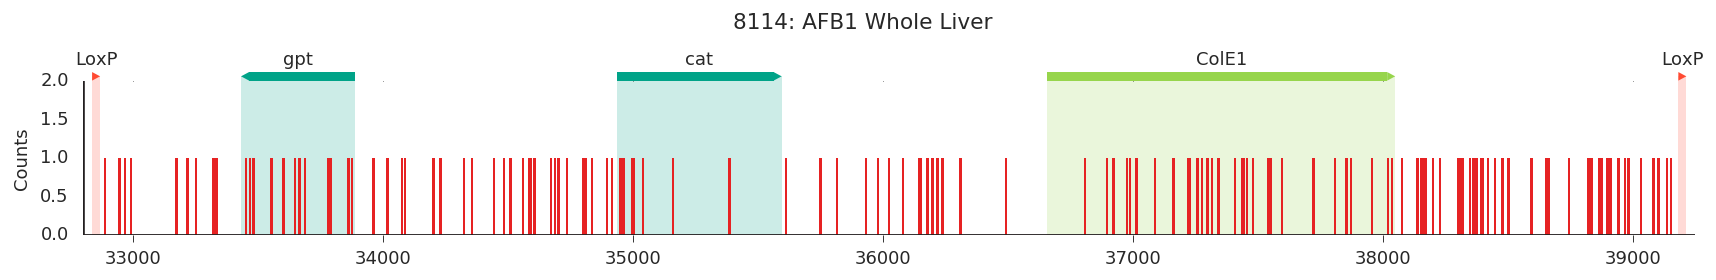

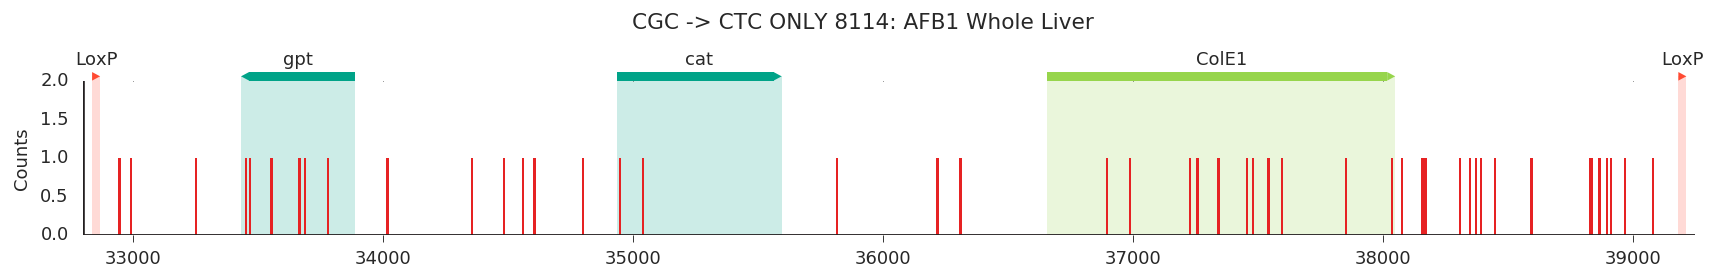

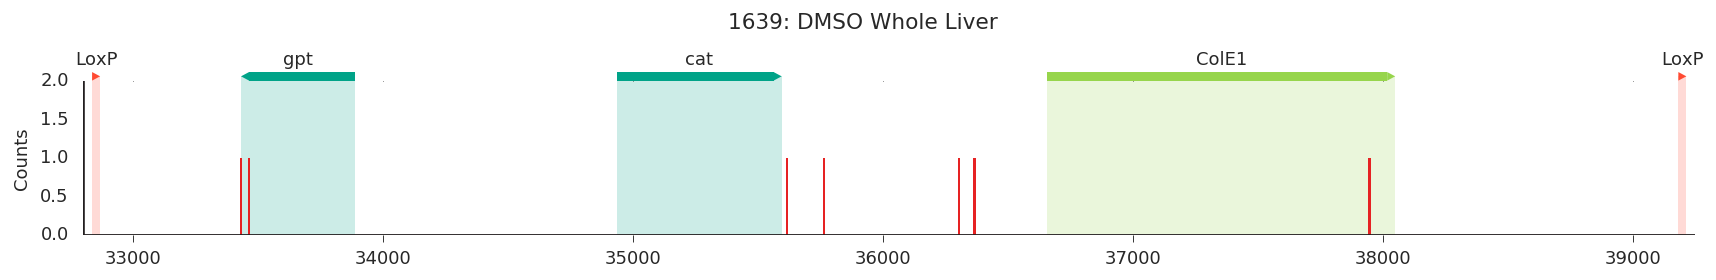

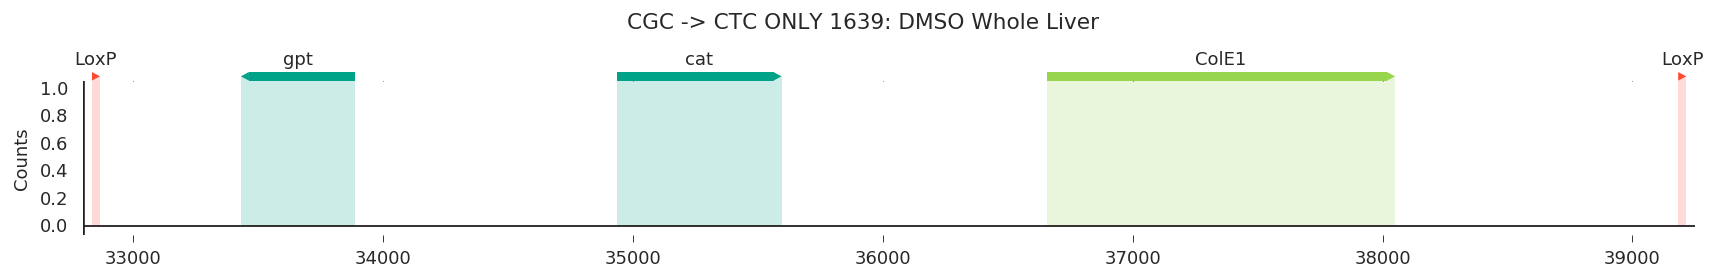

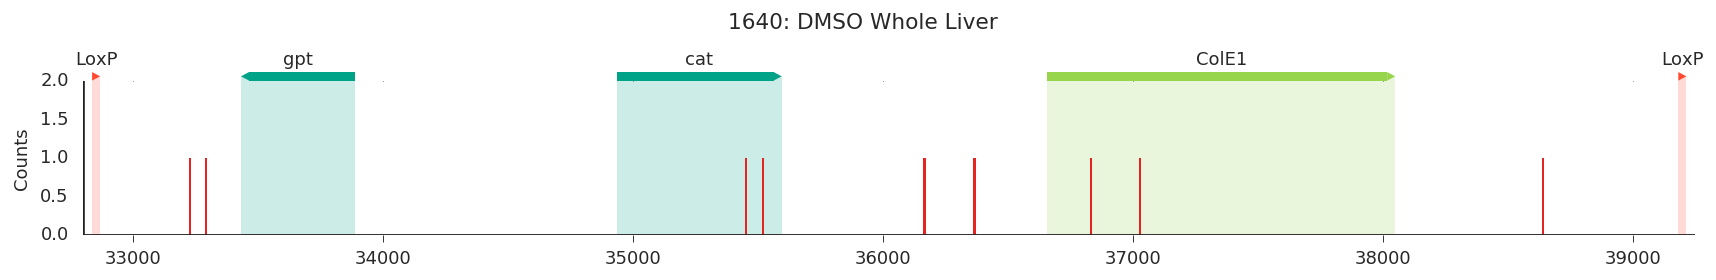

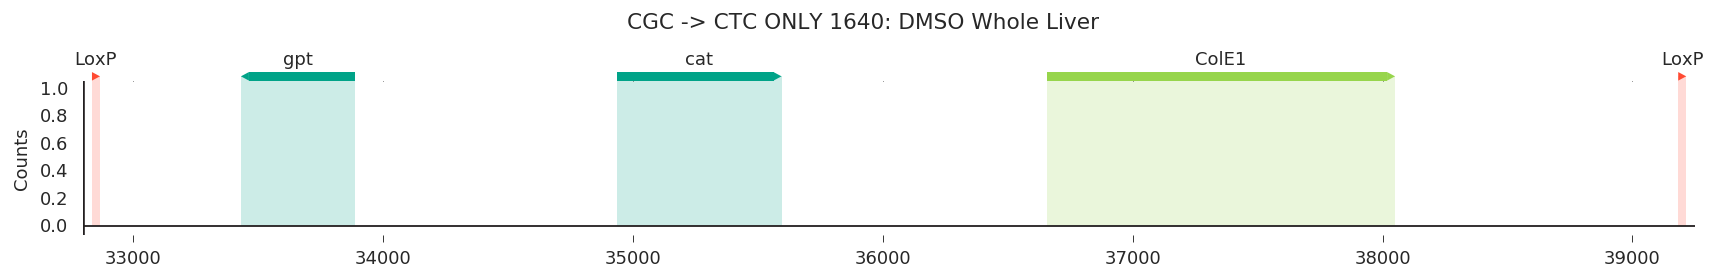

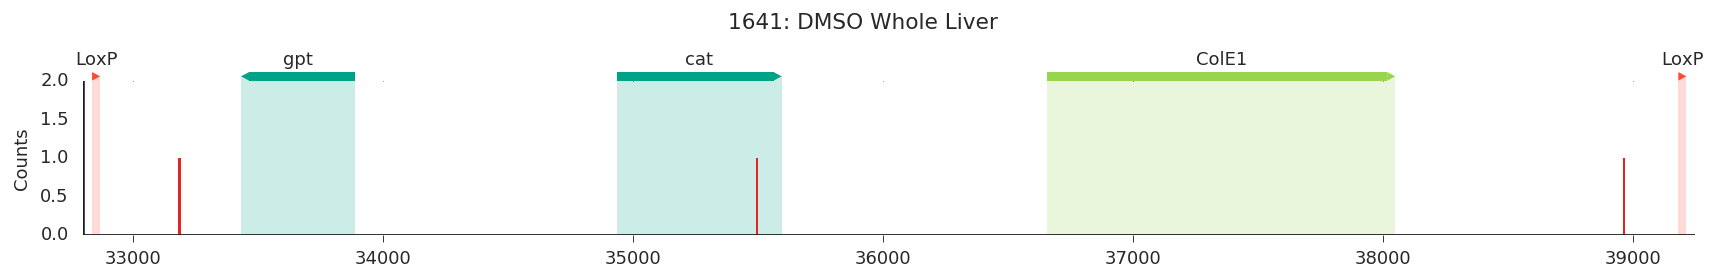

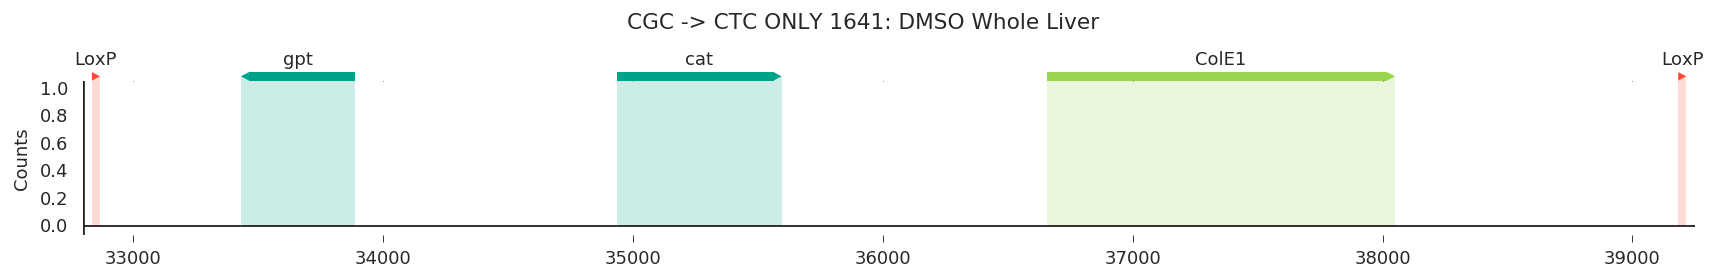

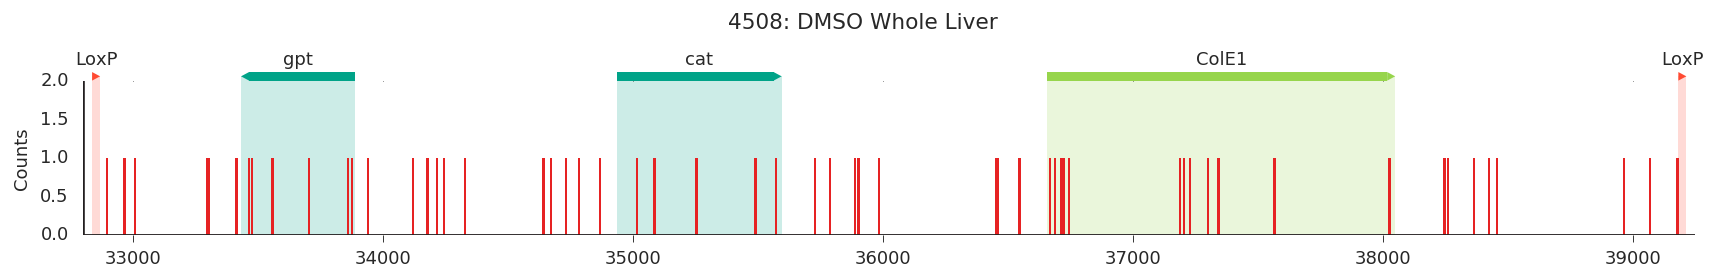

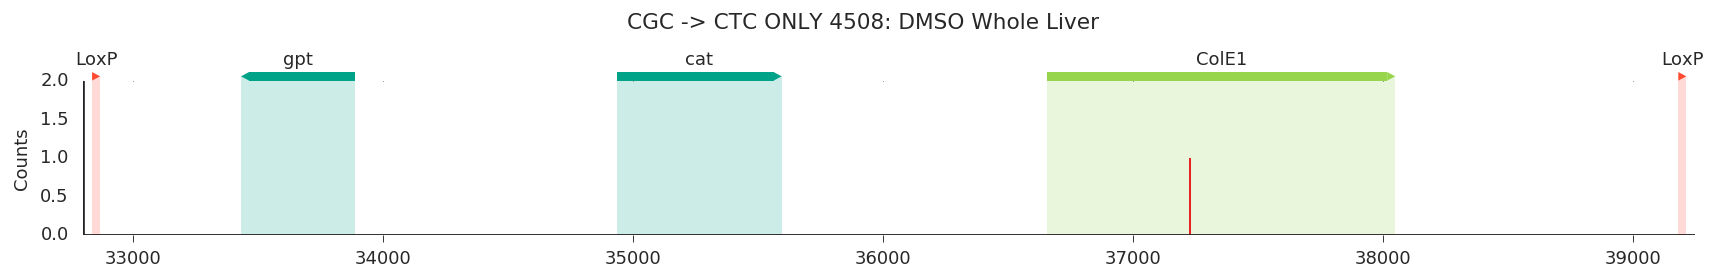

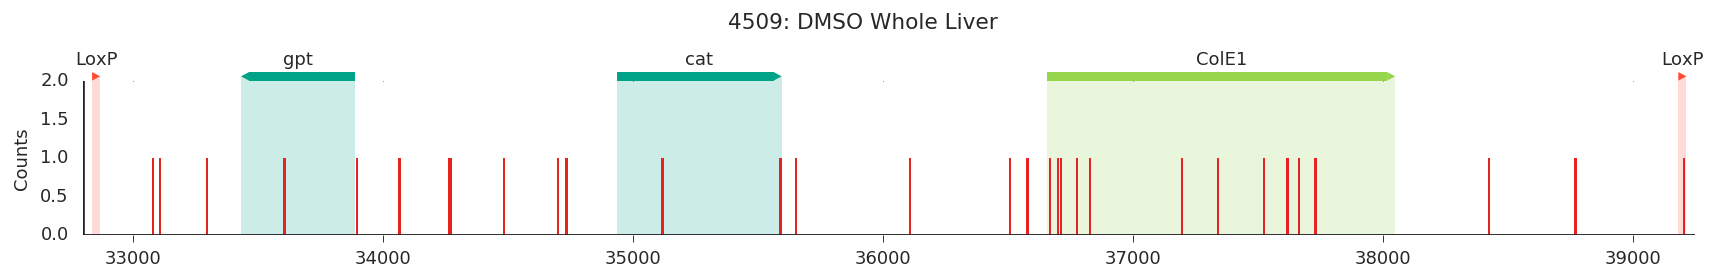

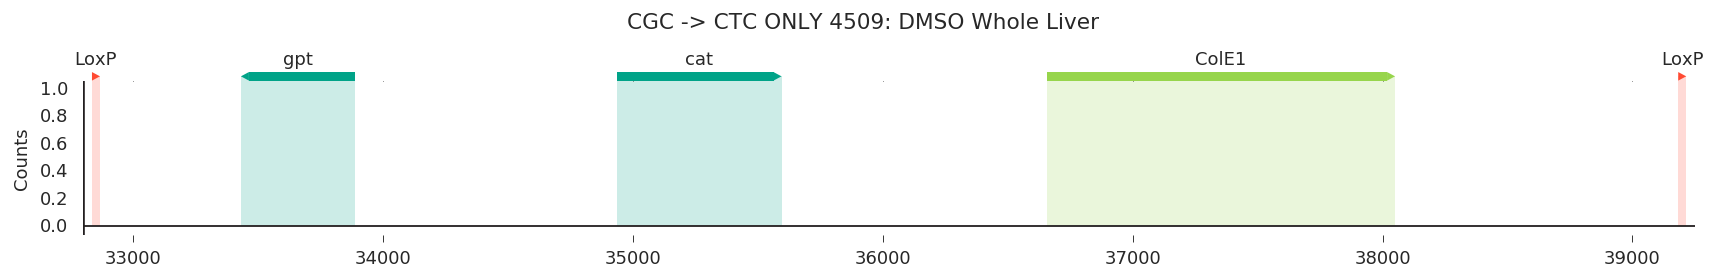

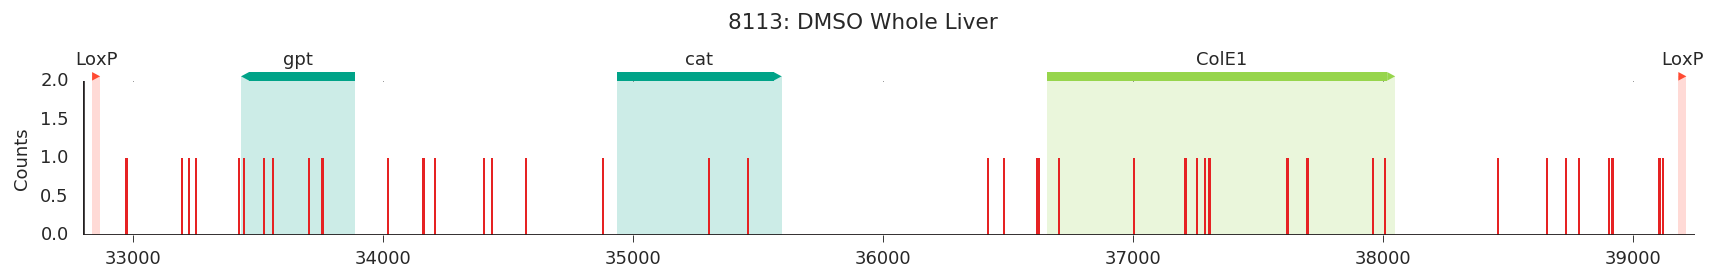

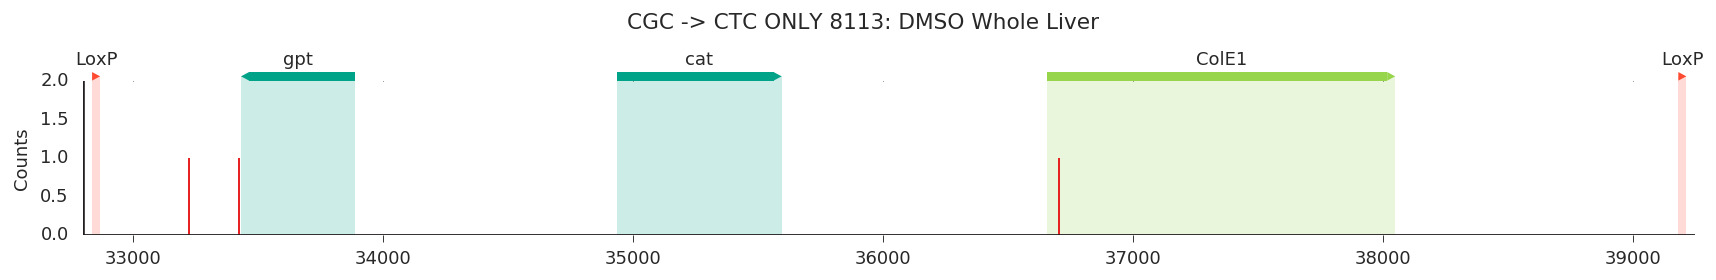

In [4]:
from siglib.mutpos import from_mutpos
from siglib.figures import variant_positions_plot

results = {}

for treatment in sorted(data_m[10].keys()):
    results[treatment] = {}
    for id, infile in sorted(data_m[10][treatment].items()):
        print('Sample: {}'.format(id))
        mutations = from_mutpos(infile, EG10fasta_file, clonality=clonality,
                                notation=notation, min_depth=min_depth, verbose=True)
        results[treatment][id] = mutations
        gff, ax = variant_positions_plot(positions=[m.position for m in sorted(set(mutations))],
                                         heights=[1 for m in sorted(set(mutations))],
                                         gff_file=EG10gff_file,
                                         title='{}: {}'.format(id, treatment),
                                         varplot_kwds={'xlabel': '', 'ylabel': 'Counts'})
        gff, ax = variant_positions_plot(positions=[m.position for m in sorted(set(mutations)) if m.context == 'GCG' and m.substitution[2] == 'A'],
                                 heights=[1 for m in sorted(set(mutations)) if m.context == 'GCG' and m.substitution[2] == 'A'],
                                 gff_file=EG10gff_file,
                                 title='CGC -> CTC ONLY {}: {}'.format(id, treatment),
                                 varplot_kwds={'xlabel': '', 'ylabel': 'Counts'})

Visualize Spectrum of Mutations in 3-mer Contexts
---

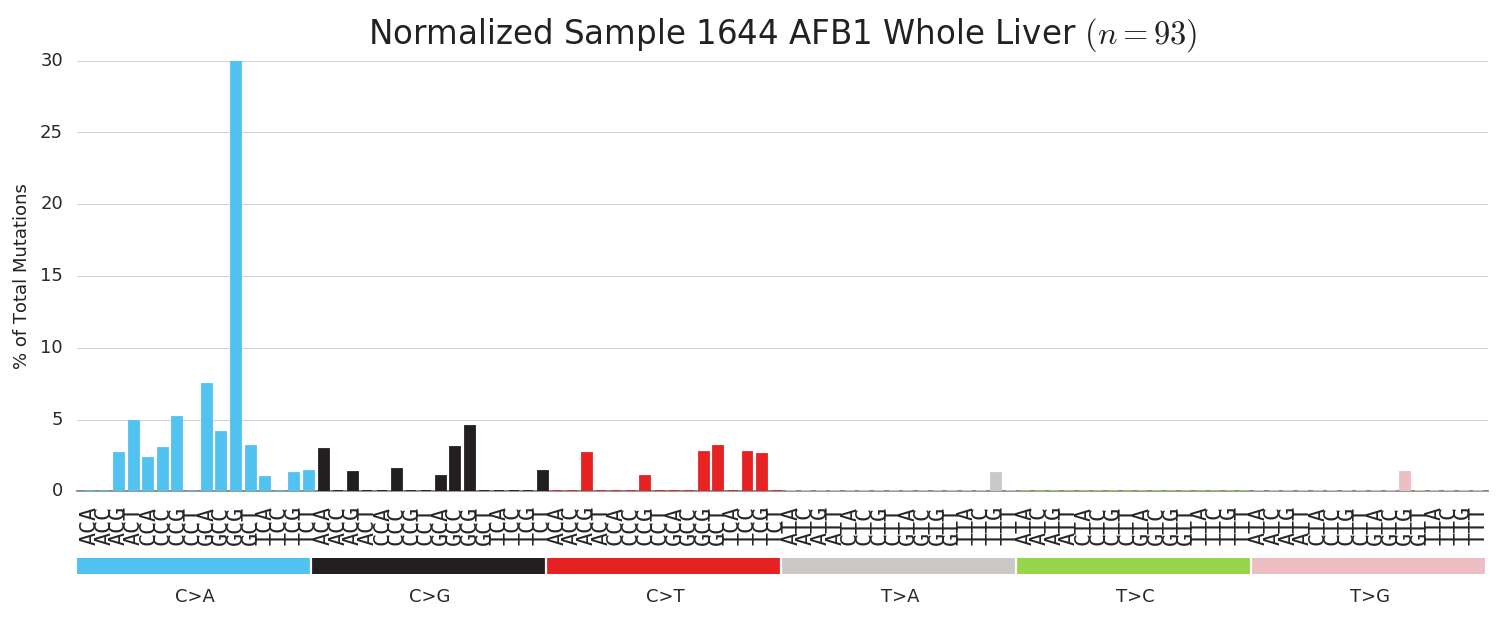

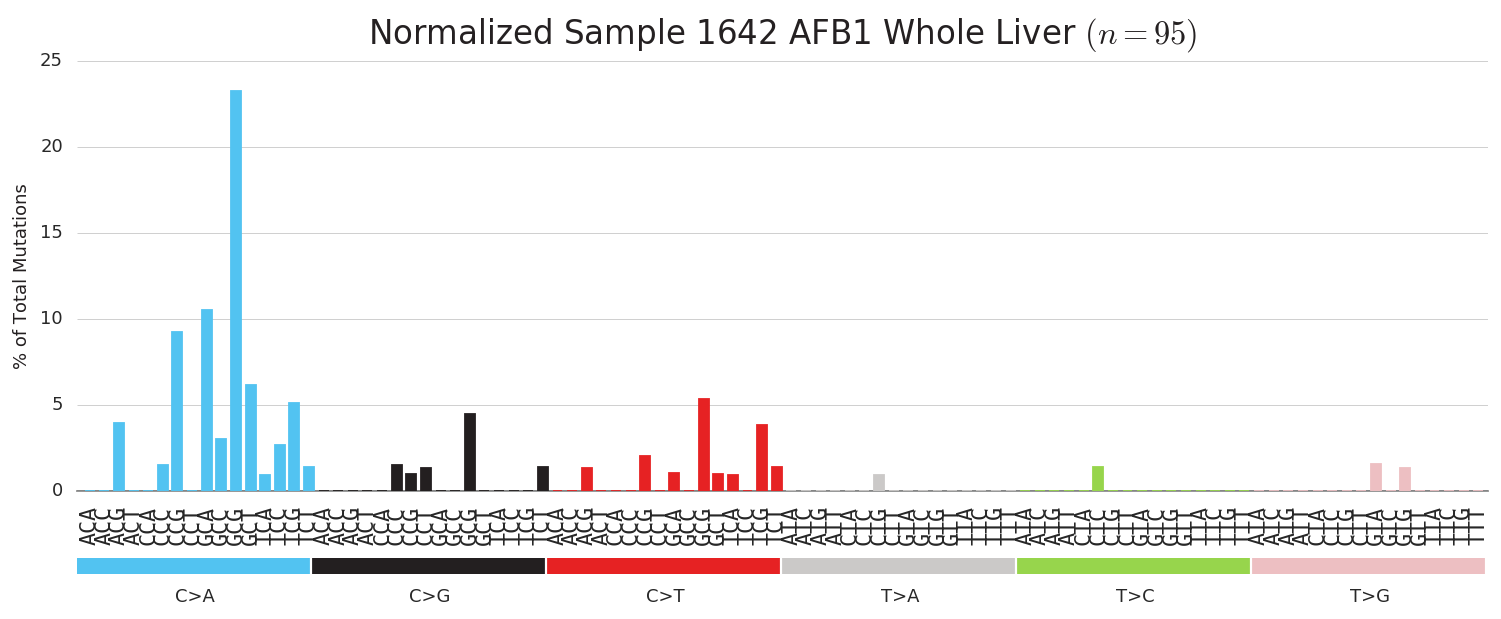

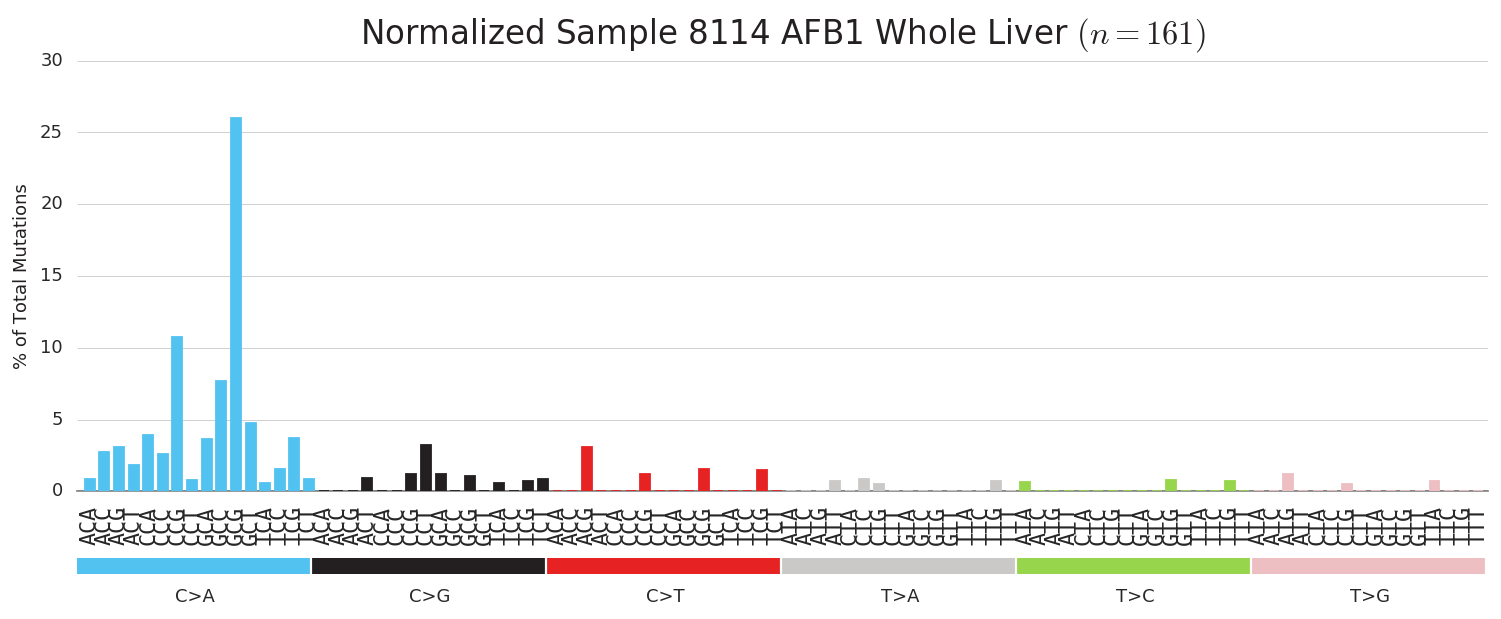

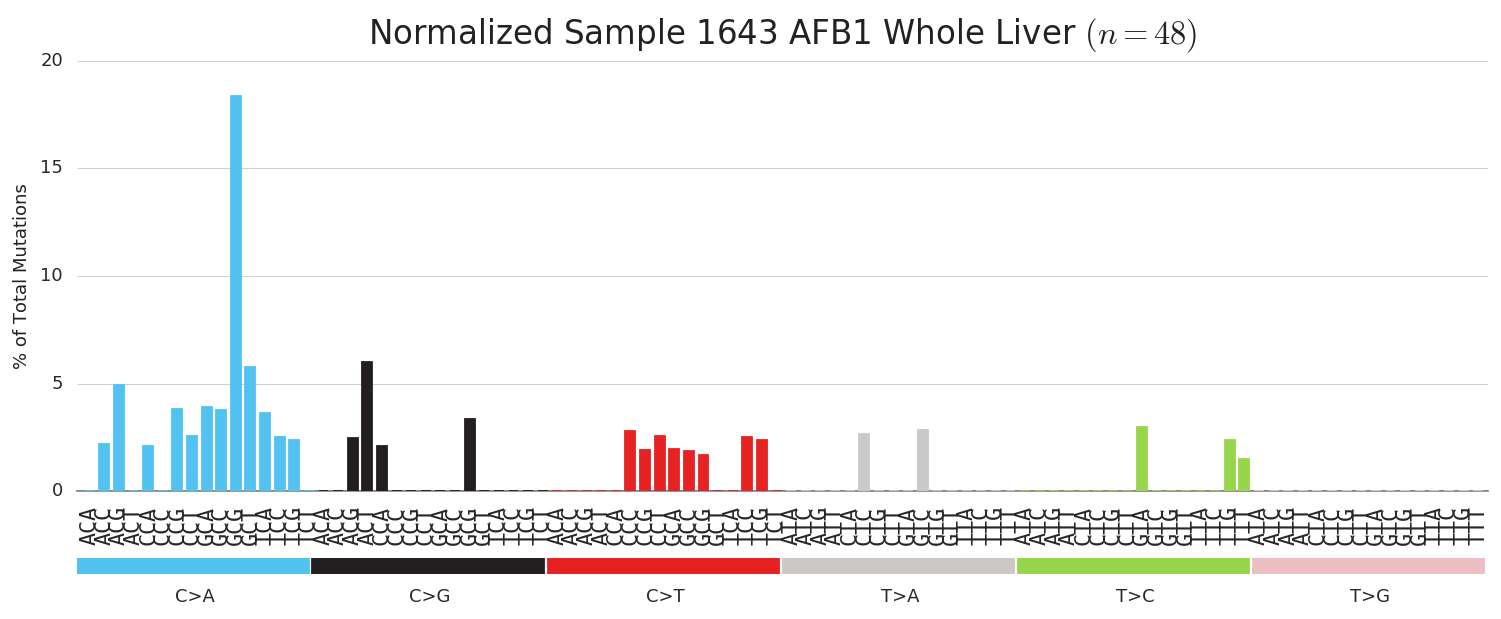

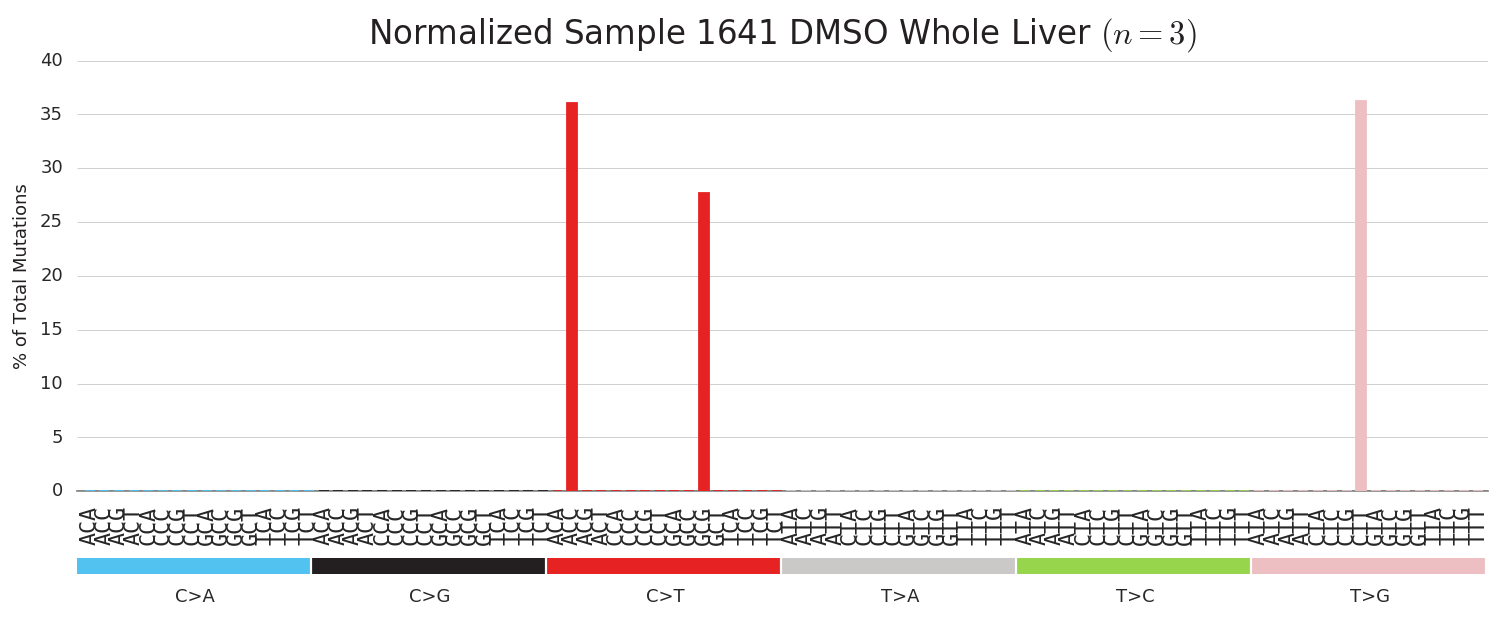

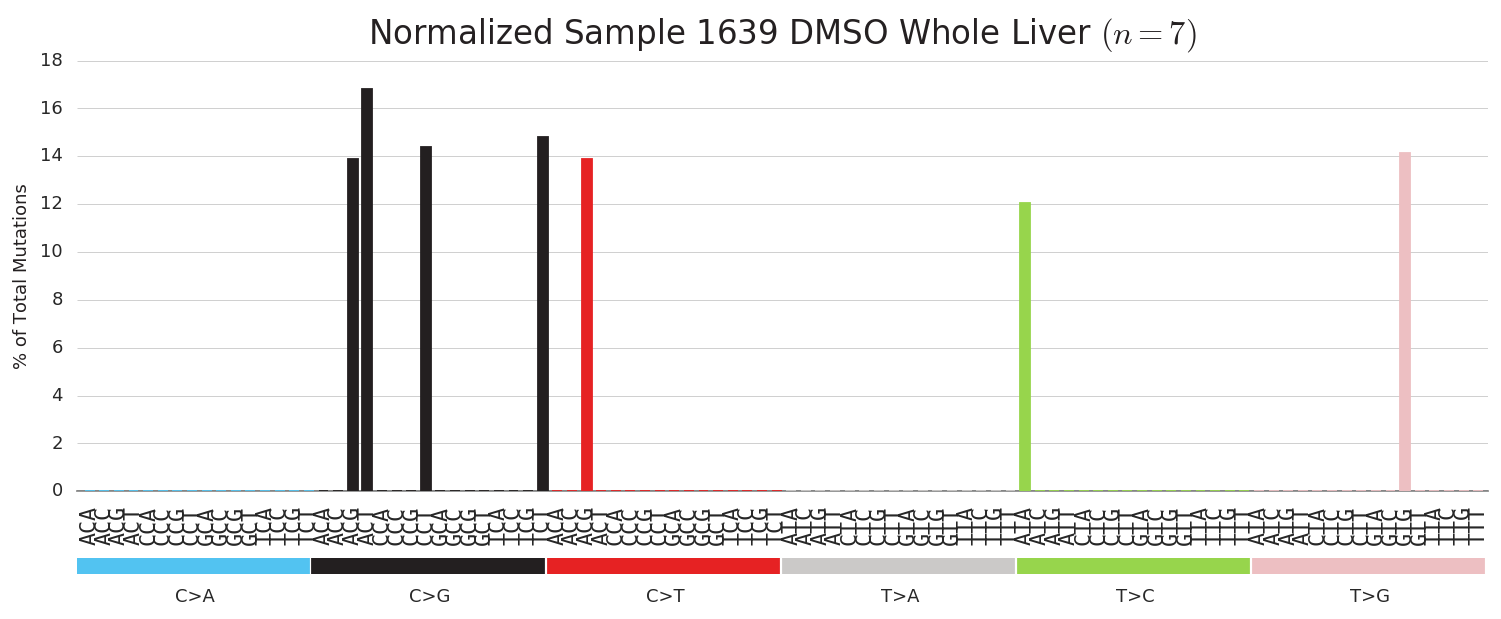

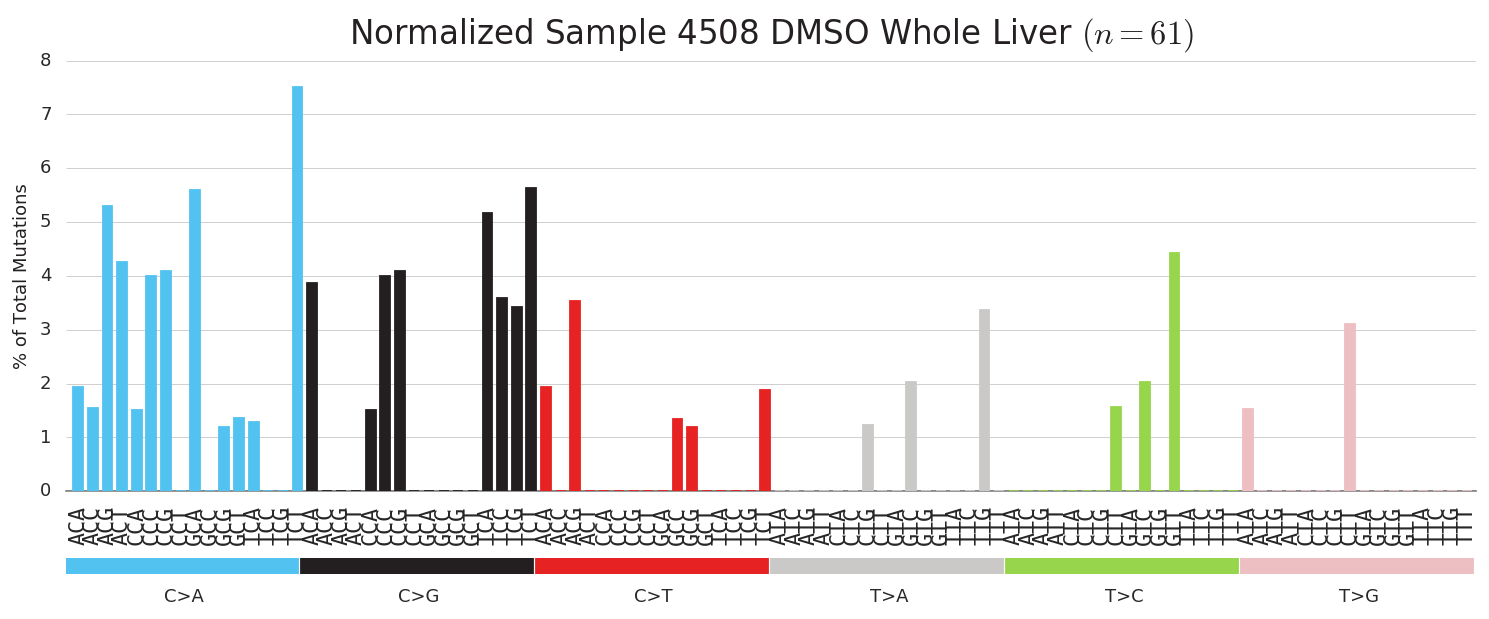

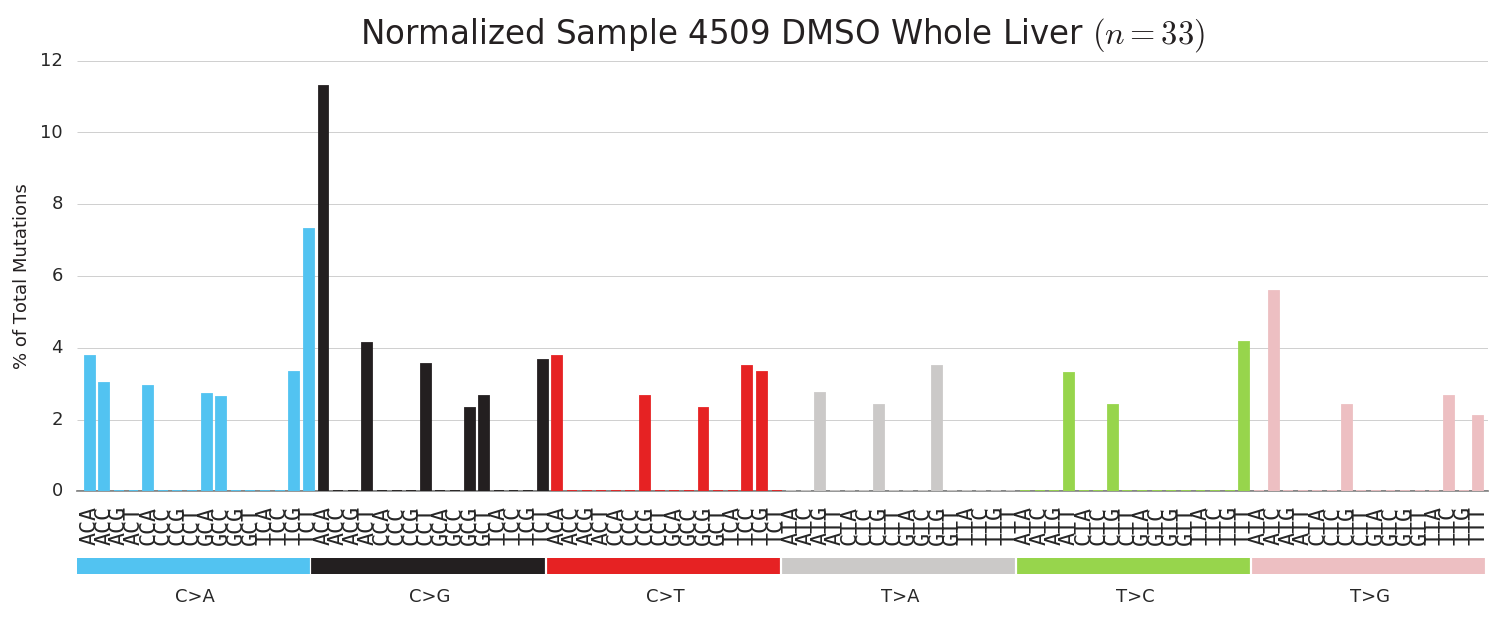

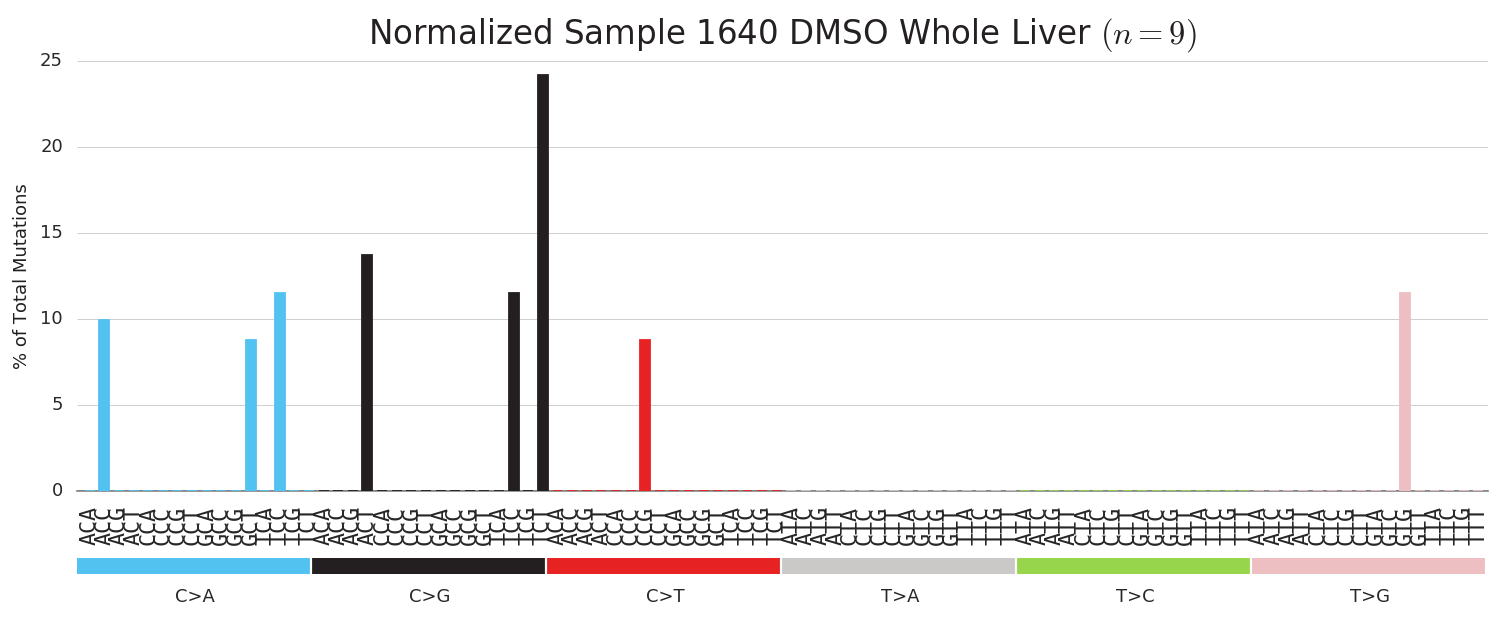

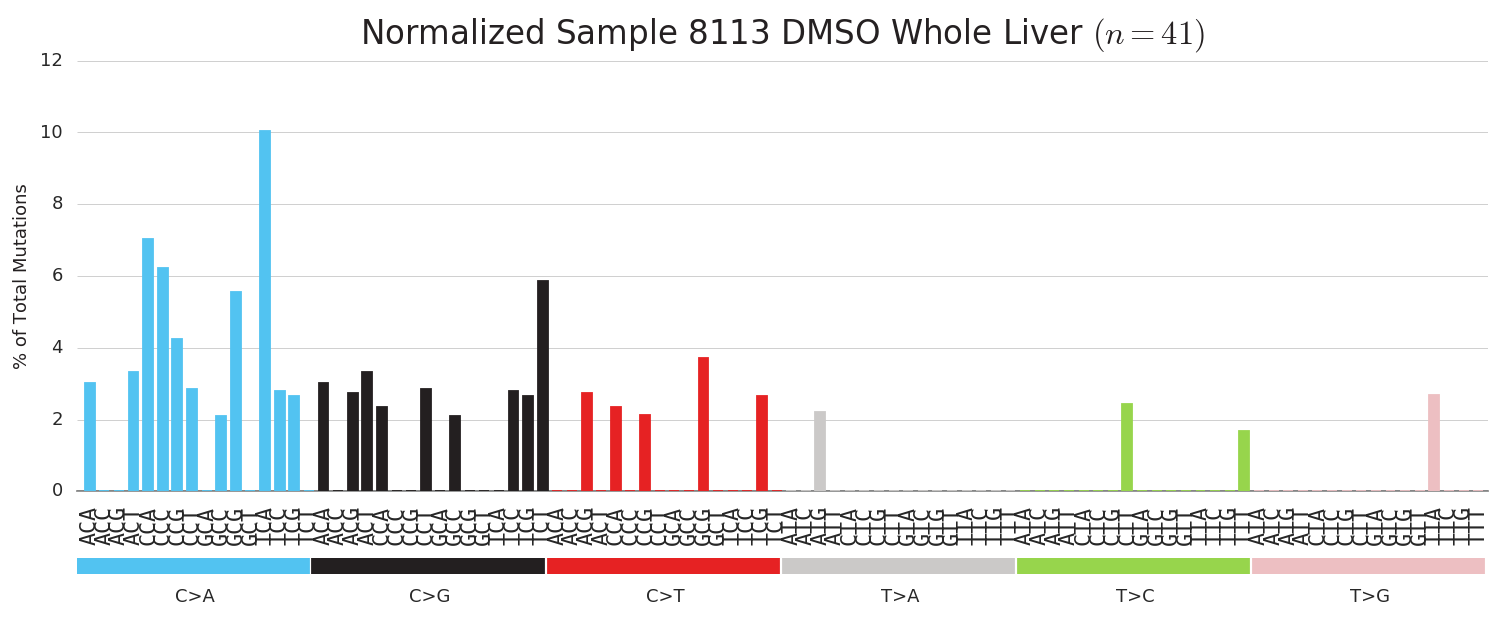

In [5]:
from siglib.utils import Spectrum
from siglib.figures import spectrum_map

for treatment in results:
    for id, mutations in results[treatment].items():
        spectrum = Spectrum(notation=notation, kmer=3)
        for mutation in set(mutations):
            spectrum[str(mutation.substitution), str(mutation.context)] += 1
        title = 'Normalized Sample {} {} $(n={})$\n\n'.format(id, treatment, spectrum.variant_total)
        spectrum_map(x=1, y=1,
                     heights=[[x * 100 for x in spectrum.normalized_proportion(j.normal())]],
                     xlabels=[spectrum.contexts],
                     labels=sorted(set(spectrum.sub_types)),
                     titles=[title])

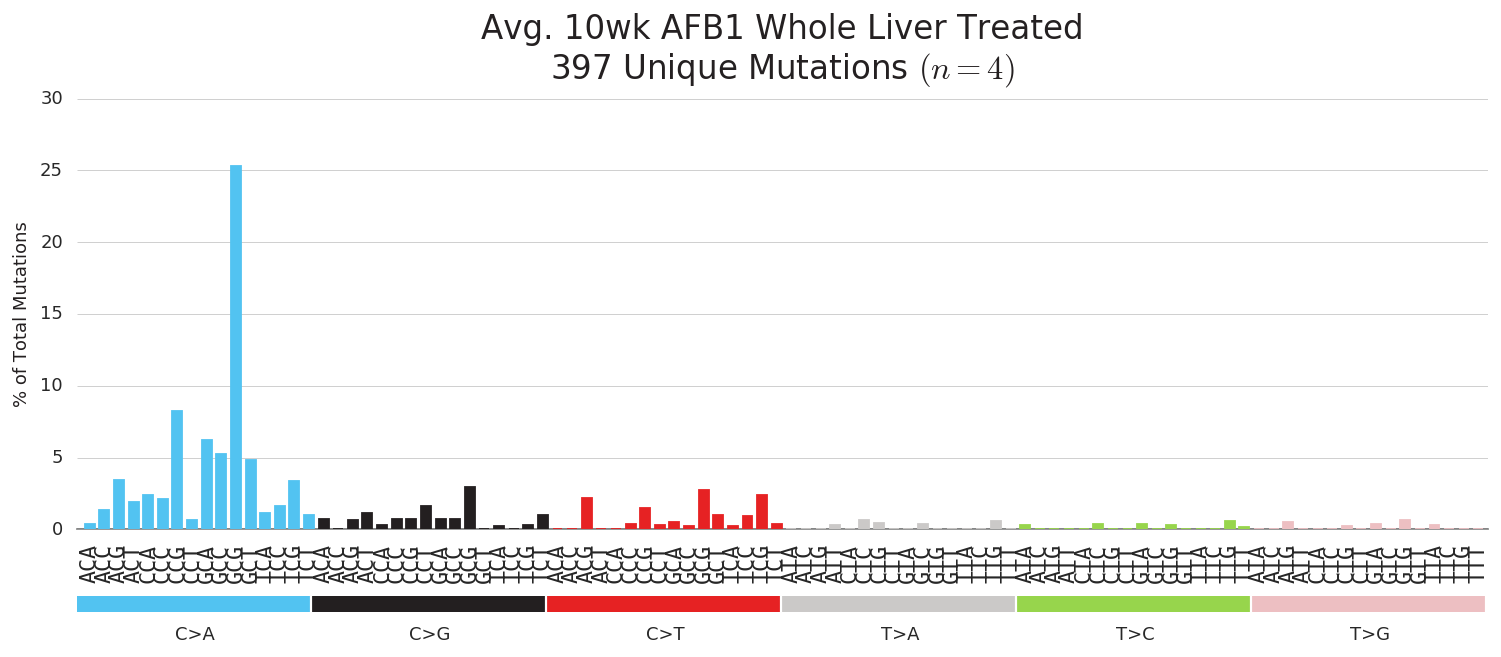

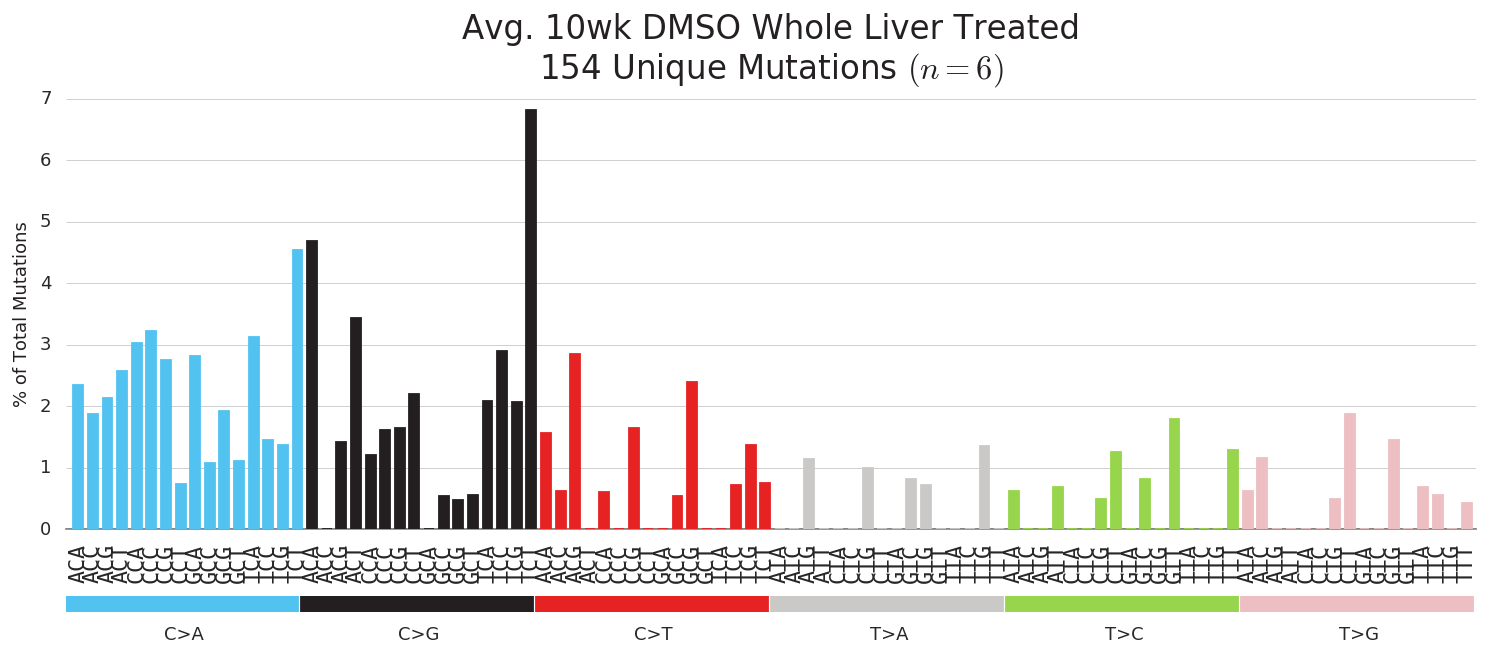

In [6]:
import matplotlib.pyplot as plt
from siglib.motifs import genome_browser

class Gene(object):
    def __init__(self, start, end, name):
        self.start = start
        self.end = end
        self.name = name


filenames = {
    'AFB1 Whole Liver': 'A10',
    'DMSO Whole Liver': 'D10',
}

for treatment in results.keys():
    outfile = filenames[treatment]
    full_sum = Spectrum(notation=notation)
    samples = 0
    for id, mutations in results[treatment].items():
        samples += 1
        for mutation in mutations:
            mutation.sample = treatment
        for mutation in set(mutations):
            full_sum[str(mutation.substitution), str(mutation.context)] += 1
    print(treatment, full_sum.values())
    title = 'Avg. 10wk {} Treated\n{} Unique Mutations $(n={})$\n\n'.format(treatment, full_sum.variant_total, samples)
    spectrum_map(x=1, y=1,
                 heights=[[x * 100 for x in full_sum.normalized_proportion(j.normal())]],
                 xlabels=[full_sum.contexts],
                 labels=sorted(set(full_sum.sub_types)),
                 titles=[title])
    plt.savefig('{}.pdf'.format(outfile))